# Week 2: Regression Homework

## EDA

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("housing.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


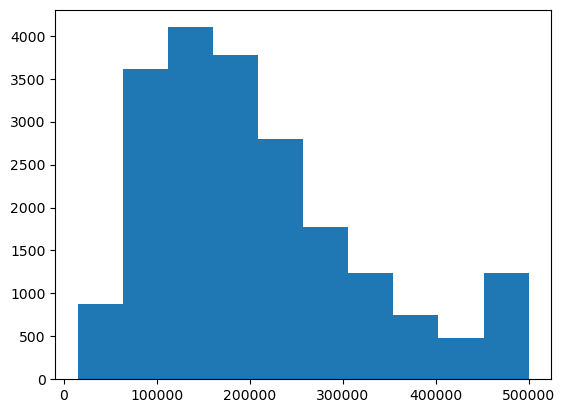

In [2]:
import matplotlib.pyplot as plt

plt.hist(df["median_house_value"]);

## Features

In [3]:
df = df[[
    "latitude",
    "longitude",
    "housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "population",
    "households",
    "median_income",
    "median_house_value"
]]

## Questions

### Question 1

Find a feature with missing values. How many missing values does it have?

In [4]:
df.isna().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

### Question 2

What's the median (50% percentile) for variable 'population'?

In [5]:
df["population"].median()

1166.0

### Split the data

- Shuffle using random seed 42
- Make a 60/20/20 split
- exlude target column
- apply log transformation to target column

In [6]:
n = len(df)

# shuffle
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

# split sizes
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

# split
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

# transform target column
y_train = np.log1p(df_train["median_house_value"])
y_val = np.log1p(df_val["median_house_value"])
y_test = np.log1p(df_test["median_house_value"])

# delete target column from df
del df_train["median_house_value"]
del df_val["median_house_value"]
del df_test["median_house_value"]


### Question 3

Try two approaches for filling missing values found before:
- fill with zeros
- fill with the mean (using training data only)

For both approaches train a linear regression model and compute RMSE on the validation set

In [7]:
# functions from lessons
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]


def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [8]:
# filling with zeros
X_zeros = df_train.copy()
X_zeros["total_bedrooms"] = X_zeros["total_bedrooms"].fillna(0)

X_zeros_val = df_val.copy()
X_zeros_val["total_bedrooms"] = X_zeros_val["total_bedrooms"].fillna(0)

w0, w  = train_linear_regression(X_zeros, y_train)
y_pred = w0 + X_zeros_val.dot(w)

rmse_zeros = rmse(y_val, y_pred)
print(f"rmse filling with zero: {round(rmse_zeros, 2)}")

rmse filling with zero: 0.33


In [9]:
# filling with mean
X_mean = df_train.copy()
train_mean = X_mean["total_bedrooms"].mean()
X_mean["total_bedrooms"] = X_mean["total_bedrooms"].fillna(train_mean)

X_mean_val = df_val.copy()
X_mean_val["total_bedrooms"] = X_mean_val["total_bedrooms"].fillna(train_mean)

w0, w  = train_linear_regression(X_mean, y_train)
y_pred = w0 + X_mean_val.dot(w)

rmse_mean = rmse(y_val, y_pred)
print(f"rmse filling with mean: {round(rmse_mean, 2)}")

rmse filling with mean: 0.33


### Question 4

Filling with zeros, train several regularized linear regressions trying `r` from `[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]`. Find the `r` that returns the best RMSE (round to 2 decimal digits).

If there are multiple options, select the smallest `r`.

In [10]:
# function from lesson
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [11]:
r_lst = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
scores = {}

for r in r_lst:
    w0, w = train_linear_regression_reg(X_zeros, y_train, r=r)
    y_pred = w0 + X_zeros_val.dot(w)
    score = rmse(y_val, y_pred)
    scores[r] = round(score, 2)

sorted(scores.items(), key=lambda x: x[1])


[(0, 0.33),
 (1e-06, 0.33),
 (0.0001, 0.33),
 (0.001, 0.33),
 (0.01, 0.33),
 (0.1, 0.33),
 (1, 0.33),
 (5, 0.34),
 (10, 0.34)]

### Question 5


* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

> Note: Standard deviation shows how different the values are.
> If it's low, then all values are approximately the same.
> If it's high, the values are different. 
> If standard deviation of scores is low, then our model is *stable*.

In [12]:
# utility function
def split_data(df, sizes=[0.2, 0.2], seed=42):
    n = len(df)

    # shuffle
    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)

    # split sizes
    val_size, test_size = sizes
    n_val = int(n * val_size)
    n_test = int(n * test_size)
    n_train = n - n_val - n_test

    # split
    X_train = df.iloc[idx[:n_train]]
    X_val = df.iloc[idx[n_train:n_train+n_val]]
    X_test = df.iloc[idx[n_train+n_val:]]

    # transform target column
    y_train = np.log1p(X_train["median_house_value"])
    y_val = np.log1p(X_val["median_house_value"])
    y_test = np.log1p(X_test["median_house_value"])

    # delete target column from df
    del X_train["median_house_value"]
    del X_val["median_house_value"]
    del X_test["median_house_value"]

    return X_train, y_train, X_val, y_val, X_test, y_test


In [13]:
scores = []
for seed in range(10):
    # split
    X_train, y_train, X_val, y_val, _, _ = split_data(df, seed=seed)
    
    # fill nans with 0
    X_train = X_train.fillna(0)
    X_val = X_val.fillna(0)

    # train
    w0, w = train_linear_regression(X_train, y_train)
    
    # evaluate
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    
    scores.append(score)

std = np.array(scores).std()

print(round(std, 3))


0.004


### Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
* What's the RMSE on the test dataset?

In [15]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(df, seed=9)

# merge train and validation
X = pd.concat([X_train, X_val])
y = pd.concat([y_train, y_val])

# fill missing values with 0
X = X.fillna(0)

# train
w0, w = train_linear_regression_reg(X, y, r=0.001)

# evaluate
y_pred = w0 + X_test.dot(w)
score = rmse(y_test, y_pred)

print(round(score, 2))

0.35
